# ITS_LIVE flowlines

This is a notebook to extract and prepare ablation zone flowlinse of velocity data for mountain glaciers in the Himalaya.

In [1]:
import xarray as xr 
import numpy as np
import pandas as pd
import geopandas as gpd 
import rioxarray as rio
import rioxarray.merge as merge
import itslivetools
import urllib.request
import json
import os
from osgeo import gdal
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from skimage.morphology import skeletonize
from itslivetools import *
from itslivetools import itslive_setup

## Read in data

### ITS_LIVE

In [2]:
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url_catalog:
    itslive_catalog = json.loads(url_catalog.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In [3]:
url = itslivetools.find_granule_by_point(itslive_catalog, [88.2511, 27.9676])

In [4]:
dc = itslivetools.read_in_s3(url[0])

In [5]:
dc_bbox = itslivetools.get_bbox(dc, epsg = '32645')

epsg:32645


### NASADEM 

In [6]:
dem_dir = '/home/emmamarshall/Desktop/data/nasadem/'
dem_ls = os.listdir(dem_dir)
dem_ls = [dem_ls[element] for element in range(len(dem_ls)) if '.nc' in dem_ls[element]]

In [7]:
qgis_dem = xr.open_dataset('/home/emmamarshall/Desktop/data/nasadem/merged_dem_qgis.nc').squeeze()

In [8]:
#steps to do outside of function on entire data object (for dem and itslive): write crs
qgis_dem = qgis_dem.rio.write_crs('EPSG:4326')
dc = dc.rio.write_crs('EPSG:32645')
#reproject dem to local utm
dem_prj = qgis_dem.rio.reproject('EPSG:32645')

In [9]:
dem_bbox = itslivetools.get_bbox(dem_prj, epsg='32645')

epsg:32645


<AxesSubplot:>

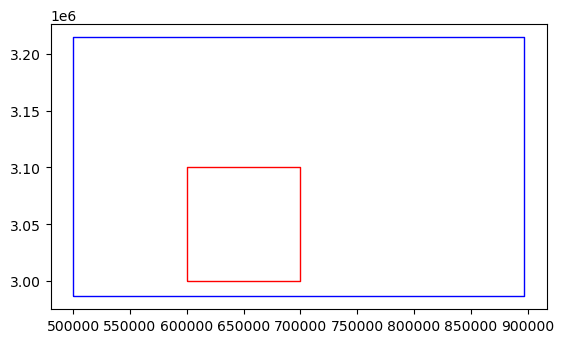

In [10]:
fig, ax = plt.subplots()
dem_bbox.plot(ax=ax, facecolor='None', edgecolor='blue')
dc_bbox.plot(ax=ax, facecolor='None', edgecolor='red')
#rgi_sub.plot(ax=ax, color='orange')
#rgi_set.plot(ax=ax, color = 'green')

### RGI outlines

In [11]:
rgi = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
rgi.head(3)
rgi_prj = rgi.to_crs('epsg:32645')

rgi_sub = gpd.sjoin(rgi_prj, dc_bbox, how='inner')

In [12]:
#list of glaciers w/ term type specified
term_types = pd.read_csv('hma_glacier_term_types_1021.csv')


In [13]:
#just the glaciers that i've categorized term type for so far
rgi_set = rgi_sub.loc[rgi_sub['RGIId'].isin(term_types['RGI_ID'])]


In [14]:
#glims ids of the term type categorized glaciers, to be used to extract centerlines
glims_set = rgi_set['GLIMSId']

### Centerline data

In [15]:
sa_east_ablationlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_ablationlines/15_rgi60_SouthAsiaEast_Ablationlines.shp')
sa_east_centerlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_centerlines/15_rgi60_SouthAsiaEast_final_lines.shp')
sa_east_lowestPoints = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_lowestPoints/15_rgi60_SouthAsiaEast_minimumpoints.shp')

In [16]:
rgi_set.loc[rgi_set['RGIId'] == 'RGI60-15.10444']

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
10443,RGI60-15.10444,G088132E27989N,20100128,-9999999,88.132,27.989,15,2,5.486,5705,...,4792,0,0,1,0,9,9,CN5O197B0043,"POLYGON ((609813.543 3097656.632, 609825.527 3...",0


In [17]:
sa_east_ablationlines.loc[sa_east_ablationlines['GLIMS_ID'] == 'G088132E27989N']

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry


In [18]:
glacier_intersect_ls = sa_east_ablationlines.loc[sa_east_ablationlines['GLIMS_ID'].isin(glims_set)]
glacier_intersect_ls

zhang_glaciers_sub = glacier_intersect_ls['GLIMS_ID'].to_list()


## Build IndGlacier objects

In [19]:
def ind_glacier_data_prep(rgi_id, rgi_full, itslive_dc, dem_obj, centerlines, ablationlines, lowestpoints, utm_code):
    '''function to prepare data to create an object of the `IndGlacier` class for a single glacier.
    Pass in RGI ID of glacier of interest as well as full data objects of RGI gpdf, itslive datacube, 
    nasadem and the u tm code fo the glacier.I feel like at scale this is probably a really inefficient way to build objects'''
    
    #clip rgi to glacier
    single_rgi = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    print(single_rgi['RGIId'])
    #print(single_rgi)
    #extract glims id - will use to extract centerlines
    glims_id = single_rgi['GLIMSId'].values
    
    
    #clip dem and itslive
    dem_clip = dem_obj.rio.clip(single_rgi.geometry, dem_obj.rio.crs).squeeze().transpose()
    itslive_clip = itslive_dc.rio.clip(single_rgi.geometry, itslive_dc.rio.crs)
    dem_clip_downsamp = dem_clip.interp_like(itslive_clip, method = 'nearest')
    itslive_clip['z'] = dem_clip_downsamp.Band1
    
    #centerline objects
    centerline = centerlines.loc[centerlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    ablationline = ablationlines.loc[ablationlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    lowestpoint = lowestpoints.loc[lowestpoints['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    
    #flowline object
    
    #centerline = centerline.to_crs(utm_code)
    #ablationline = ablationline.to_crs(utm_code)
    #lowestpoint = lowestpoints.to_crs(
    
    #creat object of IndGlacier class
    rgi_outline = single_rgi
    glacier = IndGlacier(rgi_id, rgi_outline, dem_clip_downsamp, itslive_clip, centerline, ablationline, lowestpoint)
    
    return glacier

In [20]:
rgi_set = rgi_set[rgi_set.RGIId != 'RGI60-15.10444']

In [21]:
#need to subset `term_types` to only have glaciers that are in glacier set:

In [22]:
term_types = term_types.loc[term_types['RGI_ID'].isin(rgi_set['RGIId'])]

In [23]:
len(term_types)

21

In [24]:
land_terms = term_types.loc[term_types['TermType'] == 'Land']
lake_terms = term_types.loc[term_types['TermType'] == 'Lake']

In [25]:
land_ids = list(land_terms['RGI_ID'])
lake_ids = list(lake_terms['RGI_ID'])

In [26]:
def make_glacier_objects(glacier_ids_ls, rgi_gpdf, itslive, dem, centerlines, ablationlines, lowestpoint, epsg):
    
    '''this function takes a list of glacier ids, a gpdf of all rgi outlines, itslive granule, dem mosaic,  gpdfs for centerlines, ablation lines and lowestpoint and epsg code. 
    returns a list of objects where each element is of type IndGlacier and it contains all the data inputs. it applies the ind_glacier_data_prep() function to each glacier id passed
    '''
    glaciers = [] 
    
    for element in range(len(glacier_ids_ls)):
        
        glaciers.append(ind_glacier_data_prep(glacier_ids_ls[element], rgi_gpdf, itslive, dem, centerlines, ablationlines, lowestpoint, epsg))
        
    return glaciers
    
                            

In [27]:
land_glacier_ls = make_glacier_objects(land_ids, rgi_set, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

10457    RGI60-15.10458
Name: RGIId, dtype: object
10455    RGI60-15.10456
Name: RGIId, dtype: object
10445    RGI60-15.10446
Name: RGIId, dtype: object
10447    RGI60-15.10448
Name: RGIId, dtype: object
10425    RGI60-15.10426
Name: RGIId, dtype: object
10435    RGI60-15.10436
Name: RGIId, dtype: object
10441    RGI60-15.10442
Name: RGIId, dtype: object
10415    RGI60-15.10416
Name: RGIId, dtype: object
10403    RGI60-15.10404
Name: RGIId, dtype: object


In [28]:
lake_glacier_ls = make_glacier_objects(lake_ids, rgi_set, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

10462    RGI60-15.10463
Name: RGIId, dtype: object
10463    RGI60-15.10464
Name: RGIId, dtype: object
2930    RGI60-15.02931
Name: RGIId, dtype: object
3255    RGI60-15.03256
Name: RGIId, dtype: object
10433    RGI60-15.10434
Name: RGIId, dtype: object
10406    RGI60-15.10407
Name: RGIId, dtype: object
10384    RGI60-15.10385
Name: RGIId, dtype: object


## Break 

Every object of `lake_glacier_ls` and `land_glacier_ls` should be `IndGlacier`

In [30]:
for element in range(len(lake_glacier_ls)):
    print(type(lake_glacier_ls[element]))

<class 'itslivetools.itslive_setup.IndGlacier'>
<class 'itslivetools.itslive_setup.IndGlacier'>
<class 'itslivetools.itslive_setup.IndGlacier'>
<class 'itslivetools.itslive_setup.IndGlacier'>
<class 'itslivetools.itslive_setup.IndGlacier'>
<class 'itslivetools.itslive_setup.IndGlacier'>
<class 'itslivetools.itslive_setup.IndGlacier'>


Now want to create `IndGlacier_flowline` class and objects of that class. I think it would be more efficient to have it be a separate rather than inherited class? 

In [31]:
class GlacierFlowline:
    
    def __init__(self, rgi_id, rgi_outline, flowline_ds, norm_flowline=None):
        
        self.rgi_id = rgi_id
        self.rgi_outline = rgi_outline
        self.flowline_ds = flowline_ds
        self.norm_flowline = norm_flowline
        
#def glacier_flowline_build(full_glacier_obj):
    
def build_GlacierFlowline(IndGlacier_obj):
    
    rgi_id = IndGlacier_obj.rgi_id
    rgi_outline = IndGlacier_obj.rgi_outline
    flowline_ds = IndGlacier_obj.calc_flowline()
    
    flowline = GlacierFlowline(rgi_id, rgi_outline, flowline_ds)
    
    return flowline

In [32]:
def normalize(arr, t_min, t_max):
    '''simple normalizing fn, from geeksforgeeks. takes min and max value to normalize to'''
    
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [33]:
def create_normalized_object(input_ds):
    '''takes a flowline object (xarray obj w/ points dim and distance var), returns a new xarray obj w/ a normalized dist dim'''
    
    input_ds = input_ds.swap_dims({'points':'distance'})
    norm_ds = input_ds.copy()
    norm_ds.coords['distance'] = normalize(norm_ds['distance'],0,1000)
    
    return norm_ds

In [34]:
toy_glacier = ind_glacier_data_prep('RGI60-15.10463', rgi_sub, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

10462    RGI60-15.10463
Name: RGIId, dtype: object


In [35]:
toy_flowline = build_GlacierFlowline(toy_glacier)

In [36]:
toy_flowline.norm_flowline = create_normalized_object(toy_flowline.flowline_ds)

In [37]:
toy_flowline.norm_flowline

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, distance: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (distance) float64 6.236e+05 ... 6.221e+05
    y                          (distance) float64 3.094e+06 ... 3.098e+06
    points                     (distance) int64 220 219 218 217 216 ... 3 2 1 0
  * distance                   (distance) float64 1e+03 1e+03 ... 2.627 0.0
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, distance) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, distance) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (distance) float64 5.988e+03 5.985e+03 ... nan
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [38]:
def flowline_wrapper_ind(rgi_id, rgi_full, itslive_dc, dem_obj, centerlines, ablationlines, lowestpoints, utm_code):
    '''this should be a function to go from glacier id string to some sort of collection (tuple, dict, data tree?) of flowline xarray objects (type = GlacierFlowline)
    want to wrap ind_glacier_data_prep(), build_glacierflowline() and create_normalized_object()
    '''
    indglacier_obj = ind_glacier_data_prep(rgi_id, rgi_full, itslive_dc, dem_obj, centerlines, ablationlines, lowestpoints, utm_code)
    
    flowline_obj = build_GlacierFlowline(indglacier_obj)
    flowline_obj.norm_flowline = create_normalized_object(flowline_obj.flowline_ds)
    
    return flowline_obj

In [39]:
test = flowline_wrapper_ind('RGI60-15.02931', rgi_sub, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

2930    RGI60-15.02931
Name: RGIId, dtype: object


In [40]:
test.norm_flowline

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, distance: 157)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (distance) float64 6.598e+05 ... 6.594e+05
    y                          (distance) float64 3.096e+06 ... 3.096e+06
    points                     (distance) int64 156 155 154 153 152 ... 3 2 1 0
  * distance                   (distance) float64 1e+03 999.9 ... 115.4 0.0
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, distance) float32 dask.array<chunksize=(25372, 157), meta=np.ndarray>
    chip_size_width            (mid_date, distance) float32 dask.array<chunksize=(25372, 157), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (distance) float64 5.262e+03 5.23e+03 ... nan nan
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [41]:
len(rgi_set['RGIId'])

21

In [42]:
rgi_id_ls = rgi_set['RGIId'].to_list()

keys, vals = [], []

for element in range(len(rgi_id_ls)):
    
    key = rgi_id_ls[element]
    keys.append(key)
    val = flowline_wrapper_ind(key, rgi_sub, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')
    vals.append(val)
    
flowline_dict = dict(zip(keys, vals))

                     

2930    RGI60-15.02931
Name: RGIId, dtype: object
3251    RGI60-15.03252
Name: RGIId, dtype: object
3252    RGI60-15.03253
Name: RGIId, dtype: object
3255    RGI60-15.03256
Name: RGIId, dtype: object
10384    RGI60-15.10385
Name: RGIId, dtype: object
10403    RGI60-15.10404
Name: RGIId, dtype: object
10406    RGI60-15.10407
Name: RGIId, dtype: object
10415    RGI60-15.10416
Name: RGIId, dtype: object
10425    RGI60-15.10426
Name: RGIId, dtype: object
10433    RGI60-15.10434
Name: RGIId, dtype: object
10435    RGI60-15.10436
Name: RGIId, dtype: object
10441    RGI60-15.10442
Name: RGIId, dtype: object
10445    RGI60-15.10446
Name: RGIId, dtype: object
10447    RGI60-15.10448
Name: RGIId, dtype: object
10455    RGI60-15.10456
Name: RGIId, dtype: object
10457    RGI60-15.10458
Name: RGIId, dtype: object
10458    RGI60-15.10459
Name: RGIId, dtype: object
10460    RGI60-15.10461
Name: RGIId, dtype: object
10462    RGI60-15.10463
Name: RGIId, dtype: object
10463    RGI60-15.10464
Name: RGIId

In [75]:
flowline_dict.keys()

dict_keys(['RGI60-15.02931', 'RGI60-15.03252', 'RGI60-15.03253', 'RGI60-15.03256', 'RGI60-15.10385', 'RGI60-15.10404', 'RGI60-15.10407', 'RGI60-15.10416', 'RGI60-15.10426', 'RGI60-15.10434', 'RGI60-15.10436', 'RGI60-15.10442', 'RGI60-15.10446', 'RGI60-15.10448', 'RGI60-15.10456', 'RGI60-15.10458', 'RGI60-15.10459', 'RGI60-15.10461', 'RGI60-15.10463', 'RGI60-15.10464', 'RGI60-15.10467'])

In [80]:
land_ids_tuple = tuple(land_ids)
lake_ids_tuple = tuple(lake_ids)
land_ids_tuple

('RGI60-15.10458',
 'RGI60-15.10456',
 'RGI60-15.10446',
 'RGI60-15.10448',
 'RGI60-15.10426',
 'RGI60-15.10436',
 'RGI60-15.10442',
 'RGI60-15.10416',
 'RGI60-15.10404')

In [81]:
lake_flowlines = dict((k, flowline_dict[k]) for k in lake_ids_tuple)

In [82]:
land_flowlines = dict((k, flowline_dict[k]) for k in land_ids_tuple)

In [86]:
len(land_flowlines.keys())

9

In [96]:
reds = plt.cm.Reds
blues = plt.cm.Blues

In [97]:
blues_ls = [blues(i) for i in range(blues.N)]
reds_ls = [reds(i) for i in range(reds.N)]

In [112]:
from matplotlib import cm

color_b = cm.Blues(np.linspace(0,1,7))
color_r = cm.Reds(np.linspace(0,1,9))
color_b

array([[0.96862745, 0.98431373, 1.        , 1.        ],
       [0.84069204, 0.90163783, 0.95866205, 1.        ],
       [0.67189542, 0.81437908, 0.90065359, 1.        ],
       [0.41708574, 0.68063053, 0.83823145, 1.        ],
       [0.21568627, 0.52941176, 0.75424837, 1.        ],
       [0.06251442, 0.35750865, 0.64290657, 1.        ],
       [0.03137255, 0.18823529, 0.41960784, 1.        ]])

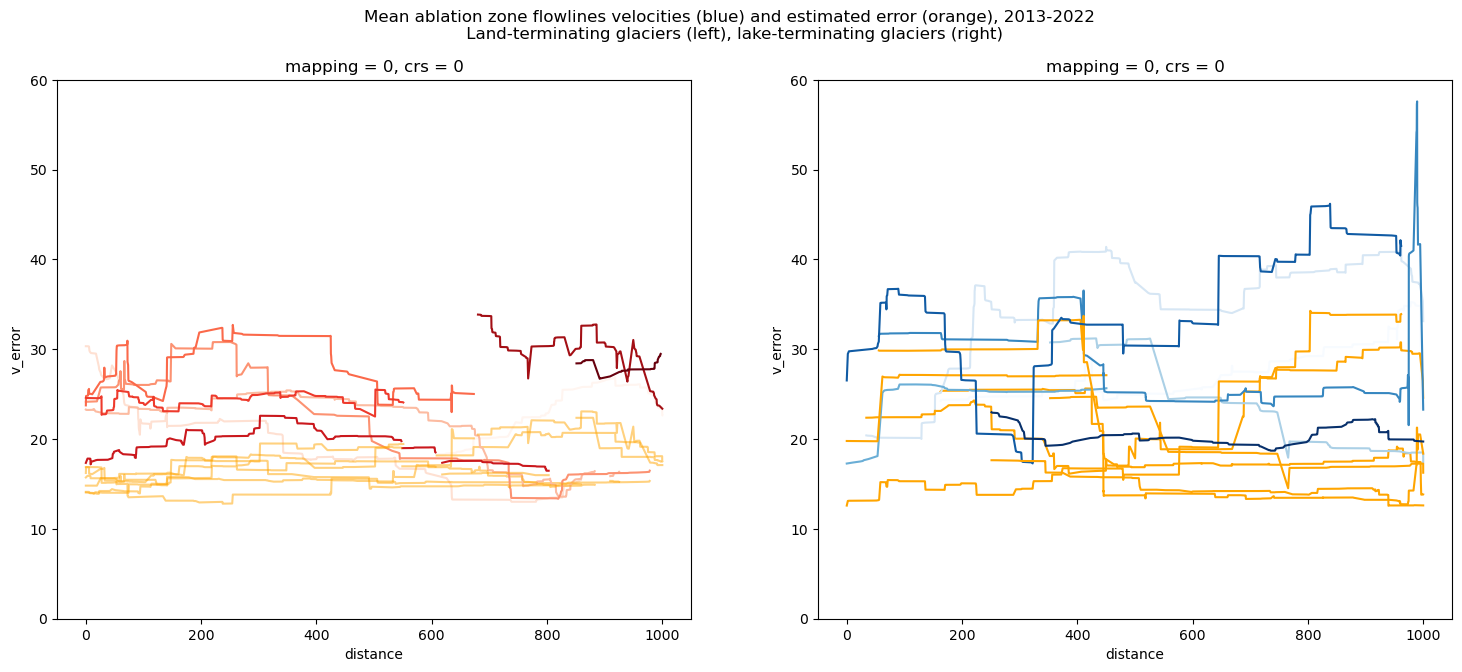

In [113]:
fig, axs = plt.subplots(ncols = 2, figsize = (18,7))
fig.suptitle('Mean ablation zone flowlines velocities (blue) and estimated error (orange), 2013-2022 \n Land-terminating glaciers (left), lake-terminating glaciers (right)')
axs[0].set_title('Land-terminating glaciers (n=9)')
axs[1].set_title('Lake-terminating glaciers (n=7)')
axs[0].set_ylabel('meters / year')
axs[1].set_ylabel('meters / year')
axs[0].set_ylim(0,60)
axs[1].set_ylim(0,60)

ticker_r = 0 
ticker_b = 0
for glacier, c in zip(land_flowlines.keys(), color_r):
    
    land_flowlines[glacier].norm_flowline.v.mean(dim='mid_date').plot(ax=axs[0], c = c, label = '')
    land_flowlines[glacier].norm_flowline.v_error.mean(dim='mid_date').plot(ax=axs[0], c = 'orange', alpha = 0.5, label = '')
    ticker_r += 1
for glacier, c in zip(lake_flowlines.keys(), color_b):
    
    lake_flowlines[glacier].norm_flowline.v.mean(dim='mid_date').plot(ax=axs[1], c= c, label = '')
    lake_flowlines[glacier].norm_flowline.v_error.mean(dim='mid_date').plot(ax=axs[1], c='orange', label = '')
    ticker_b += 1

## Non-data tree approach:

In [52]:
lake_flowlines_dict = dict(zip(lake_ids, [lake_glacier_ls[g].calc_flowline() for g in range(len(lake_ids))]))
#land_dict = dict(zip(land_ids_new, [land_glacier_ls[g].calc_flowline() for g in range(len(land_ids))]))

In [53]:
land_flowlines_dict = dict(zip(land_ids, [land_glacier_ls[g].calc_flowline() for g in range(len(land_ids))]))

In [54]:
lake_flowlines_dict.keys()

dict_keys(['RGI60-15.10463', 'RGI60-15.10464', 'RGI60-15.02931', 'RGI60-15.03256', 'RGI60-15.10434', 'RGI60-15.10407', 'RGI60-15.10385'])

In [55]:
lake_flowlines_dict['RGI60-15.10463']

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, points: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (points) float64 6.236e+05 ... 6.221e+05
    y                          (points) float64 3.094e+06 ... 3.098e+06
  * points                     (points) int64 220 219 218 217 216 ... 4 3 2 1 0
Data variables: (12/55)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (points) float64 5.988e+03 5.985e+03 ... nan nan
    distance                   (points) float64 4.405e+03 4.405e+03 ... 0.0
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [107]:
land_flowlines_dict.keys()

dict_keys(['RGI60-15.10458', 'RGI60-15.10456', 'RGI60-15.10446', 'RGI60-15.10448', 'RGI60-15.10426', 'RGI60-15.10436', 'RGI60-15.10442', 'RGI60-15.10416', 'RGI60-15.10404'])

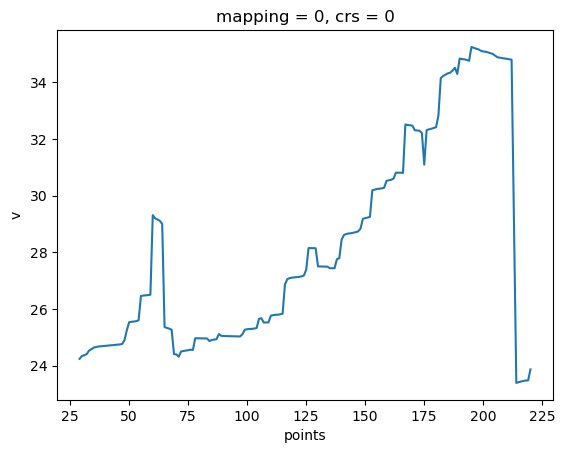

In [64]:
fig, ax = plt.subplots()
lake_flowlines_dict['RGI60-15.10463'].v.mean(dim='mid_date').plot(ax=ax)
#lake_flowlines_dict['RGI60-15.10463'].v_error.mean(dim='mid_date').plot(ax=ax, c= 'orange')

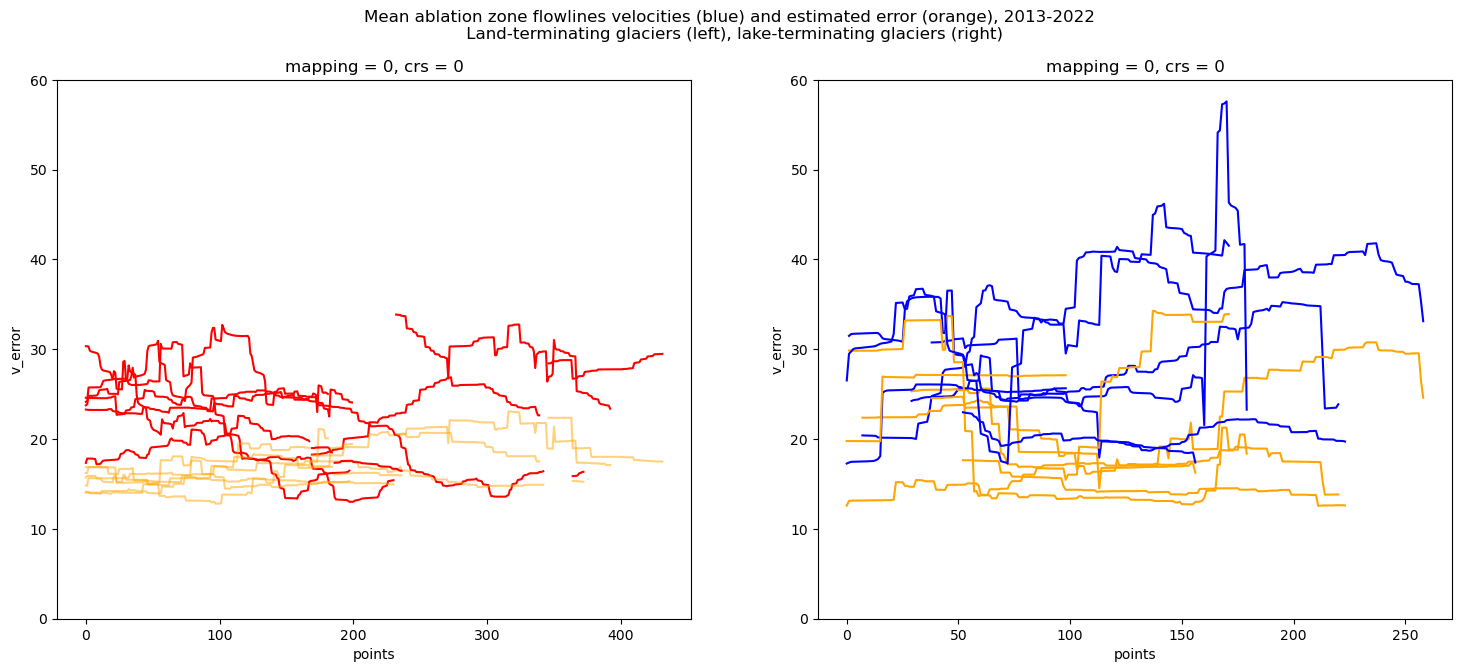

In [266]:
fig, axs = plt.subplots(ncols = 2, figsize = (18,7))
fig.suptitle('Mean ablation zone flowlines velocities (blue) and estimated error (orange), 2013-2022 \n Land-terminating glaciers (left), lake-terminating glaciers (right)')
axs[0].set_title('Land-terminating glaciers (n=9)')
axs[1].set_title('Lake-terminating glaciers (n=7)')
axs[0].set_ylabel('meters / year')
axs[1].set_ylabel('meters / year')
axs[0].set_ylim(0,60)
axs[1].set_ylim(0,60)

for glacier in land_flowlines_dict.keys():
    
    land_flowlines_dict[glacier].v.mean(dim='mid_date').plot(ax=axs[0], c = 'red', label = '')
    land_flowlines_dict[glacier].v_error.mean(dim='mid_date').plot(ax=axs[0], c = 'orange', alpha = 0.5, label = '')

for glacier in lake_flowlines_dict.keys():
    
    lake_flowlines_dict[glacier].v.mean(dim='mid_date').plot(ax=axs[1], c= 'blue', label = '')
    lake_flowlines_dict[glacier].v_error.mean(dim='mid_date').plot(ax=axs[1], c='orange', label = '');

**Issues with the above plot:**
1. x-axis is points from terminus, not meters
2. profiles are not normalized by glacier length, need to do this still

## Normalizing by glacier length

not sure the best way to approach this, maybe want to create a new class: NormalizedGlacier ? 

In [59]:
# writing my own normalize function to hopefully use with reduce ? 

def normalize(arr, t_min, t_max):
    '''simple normalizing fn, from geeksforgeeks. takes min and max value to normalize to'''
    
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [85]:
def create_normalized_object(input_ds):
    '''takes a flowline object (xarray obj w/ points dim and distance var), returns a new xarray obj w/ a normalized dist dim'''
    
    input_ds = input_ds.swap_dims({'points':'distance'})
    norm_ds = input_ds.copy()
    norm_ds.coords['distance'] = normalize(norm_ds['distance'],0,1000)
    
    return norm_ds
    

In [82]:
lake_flowlines_dict['RGI60-15.10463']

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, points: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (points) float64 6.236e+05 ... 6.221e+05
    y                          (points) float64 3.094e+06 ... 3.098e+06
  * points                     (points) int64 220 219 218 217 216 ... 4 3 2 1 0
Data variables: (12/55)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (points) float64 5.988e+03 5.985e+03 ... nan nan
    distance                   (points) float64 4.405e+03 4.405e+03 ... 0.0
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [57]:
#from sklearn import preprocessing

#make a toy object to play with thats a single dataset (single glacier)
toy_glacier = lake_flowlines_dict['RGI60-15.10463']
toy_glacier

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, points: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (points) float64 6.236e+05 ... 6.221e+05
    y                          (points) float64 3.094e+06 ... 3.098e+06
  * points                     (points) int64 220 219 218 217 216 ... 4 3 2 1 0
Data variables: (12/55)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (points) float64 5.988e+03 5.985e+03 ... nan nan
    distance                   (points) float64 4.405e+03 4.405e+03 ... 0.0
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [58]:
toy_glacier = toy_glacier.swap_dims({'points':'distance'})
toy_glacier

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, distance: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (distance) float64 6.236e+05 ... 6.221e+05
    y                          (distance) float64 3.094e+06 ... 3.098e+06
    points                     (distance) int64 220 219 218 217 216 ... 3 2 1 0
  * distance                   (distance) float64 4.405e+03 4.405e+03 ... 0.0
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, distance) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, distance) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (distance) float64 5.988e+03 5.985e+03 ... nan
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [60]:
toy_glacier.dims['distance']

221

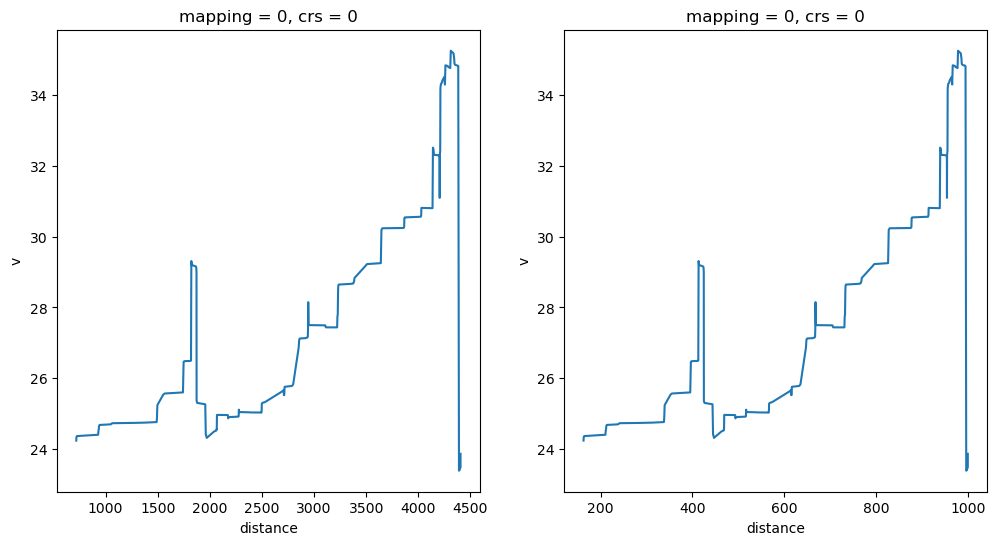

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
toy_glacier.v.mean(dim='mid_date').plot(ax=axs[0])
norm_glacier.v.mean(dim='mid_date').plot(ax=axs[1]);

In [67]:
norm_glacier = toy_glacier.copy()

In [74]:
norm_glacier.coords['distance'] = normalize(norm_glacier['distance'],0,1000)

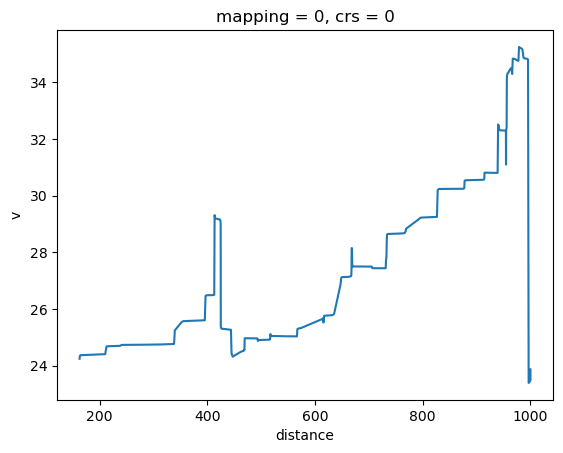

In [76]:
norm_glacier.v.mean(dim='mid_date').plot()

In [267]:
len(normalize(toy_glacier.distance.data,0,1000))

221

In [282]:
def make_normalized_flowline_obj(flowline_obj):
    
    normalized_dim = normalize(flowline_obj.distance.data,0,1000)
    
    flowline_obj['norm_dist'] = normalized_dim
    
    #normalized_obj = flowline_obj.swap_dims({'points':flowline_obj.norm_dist})
    
    return flowline_obj
    
    
    

In [284]:
toy_norm = make_normalized_flowline_obj(toy_glacier)

In [286]:
toy_norm = toy_norm.drop_dims('norm_dist')

In [287]:
toy_norm

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, points: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (points) float64 6.236e+05 ... 6.221e+05
    y                          (points) float64 3.094e+06 ... 3.098e+06
  * points                     (points) int64 220 219 218 217 216 ... 4 3 2 1 0
Data variables: (12/55)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (points) float64 5.988e+03 5.985e+03 ... nan nan
    distance                   (points) float64 4.405e+03 4.405e+03 ... 0.0
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [262]:
toy_norm = toy_glacier.distance.reduce(normalize(0,1000))

TypeError: normalize() missing 1 required positional argument: 't_max'

In [255]:
type(toy_glacier)

#toy_norm = toy_glacier.reduce(preprocessing.normalize)

preprocessing.normalize(toy_glacier.distance.data, norm = 'max')

ValueError: Expected 2D array, got 1D array instead:
array=[4405.34527869 4405.29033608 4402.99962846 4401.10412307 4399.13754954
 4397.17008868 4390.28141048 4387.3292868  4385.36162423 4383.4035981
 4377.52800787 4362.83578819 4352.05709828 4349.12209604 4347.17237629
 4346.20082153 4345.23179177 4344.26469896 4343.28740936 4342.3081596
 4341.32628345 4340.3421289  4338.36823261 4335.40017732 4321.53892226
 4311.64207747 4306.78403851 4288.40863365 4283.57316603 4278.75248676
 4260.43362123 4255.58964527 4249.6650662  4231.888698   4224.96981087
 4218.04313808 4215.08350138 4213.12655454 4212.15719266 4211.19583128
 4210.24303956 4209.29699501 4208.34085996 4207.37781442 4206.40601871
 4205.42602422 4204.43942347 4202.45278186 4187.46292326 4150.5373464
 4145.54880177 4143.55425453 4142.55594822 4140.55881254 4136.56322975
 4036.65693462 4032.66144522 4029.66876611 4027.6774663  4023.69388977
 3871.30670964 3866.32698582 3864.3354196  3862.34468035 3857.36859387
 3655.31133935 3650.33477632 3646.3577306  3640.39812009 3509.28191978
 3502.32913041 3495.37361881 3388.05565035 3384.0816133  3381.10266465
 3378.12450318 3374.15150214 3346.33490643 3236.06335054 3232.08986558
 3230.10354941 3227.13381085 3224.18160893 3221.22875352 3165.11877873
 3113.40887338 3107.44235335 3100.45650634 2974.70801279 2950.75365763
 2947.76178053 2945.77014983 2944.77557479 2943.78159684 2942.78860452
 2941.79488023 2939.80486127 2935.81845291 2916.87023546 2865.01791529
 2861.02994432 2859.03655825 2858.03997719 2856.06231425 2852.10550484
 2799.6643665  2795.70728179 2792.74052447 2789.77229593 2785.81309861
 2717.50639109 2713.54760539 2711.56896071 2710.57220727 2708.57836706
 2704.58955697 2529.0514609  2506.10995224 2502.12219273 2500.13114462
 2499.13660289 2498.1426973  2497.14894246 2495.15965972 2492.17114051
 2470.23183857 2389.46143272 2383.47890493 2380.49918493 2375.54182977
 2282.33617298 2280.35360355 2278.37125847 2276.38754906 2273.4113136
 2180.1369981  2176.16808381 2173.1919913  2170.21796979 2166.25214347
 2089.90408558 2072.05527747 2068.09139545 2066.11194747 2065.12279296
 2063.13811196 2061.15165922 2058.16918645 2041.26065723 1969.65327206
 1963.68605063 1960.71366783 1955.76900878 1878.63101764 1875.66469451
 1872.69955773 1871.71146711 1869.72770191 1866.75089354 1826.05147893
 1822.08110568 1819.10772148 1813.17596893 1755.83069053 1750.88791643
 1747.90661675 1741.92647358 1565.49413273 1559.51382095 1556.53497832
 1551.60543118 1496.38598011 1492.44223569 1489.46413894 1377.27400201
 1262.29658283 1062.73164225 1058.74095772 1055.74931662 1052.77204448
 1048.80075976  993.19312206  942.5504129   939.57182806  937.58661378
  935.6018579   934.60328814  931.60677278  927.61000374  724.75458899
  719.75917404  717.76168523  716.76270089  713.76512009  709.76711268
  464.866298    461.86812725  458.87163628  456.98320528  452.53440523
  450.75781839  449.77812016  447.81460712  445.49645977  442.8967745
  437.98589691  428.3360517   426.39403216  424.4644529   422.5362627
  421.54216937  419.55285223  417.56200015  251.22240718   22.07820269
   18.6285004    15.99442416   13.63172487   12.14437594   11.57440862
    0.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [236]:
arr = np.array([2,3,5,6,7,4,8,7,6, 10])
arr1 = np.array([1,1,2,2,3,3,3,4,4,4])
arr

array([ 2,  3,  5,  6,  7,  4,  8,  7,  6, 10])

In [241]:
normalized_arr = preprocessing.normalize([arr], norm='max')
normalized_arr

array([[0.2, 0.3, 0.5, 0.6, 0.7, 0.4, 0.8, 0.7, 0.6, 1. ]])

## Next steps

### 1. normalize flowlines by glacier length
- best way to do this?

### 2. introduce `xarray-datatree` for managing groups of glaciers
- probably best to use the `from_dict()` method but need to look into it more

### 3. break into groupby objects by season
- setup seasonal velocity analyiss

### 4. look into aggregations / analytical methods to suppress impact of noise?

## Questions about workflow
not sure about how I did these things

### 1. downsampling # of points in profile to match velocity data spatial resolution?
- on the interpolation step, I am interpolating flowline points from the gridded velocity data and the flowline profile spatial res. is higher than the itslive data so i'm not sure that some of the interpolated points are reasonable / it might have artifically higher noise? should i downsample the # of points in the flowline? do that by distance btw ind points? 

TypeError: nanmean() got an unexpected keyword argument 'di'

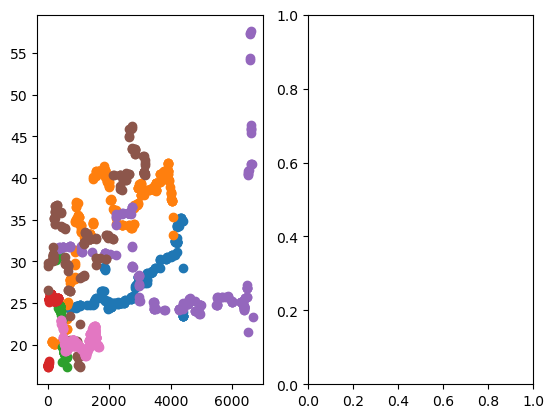

In [106]:
fig, axs = plt.subplots(ncols = 2) 

for element in lake_flowlines_dict.keys():
    
    glacier = lake_flowlines_dict[element]
    
    axs[0].scatter(glacier.distance, glacier.v.mean(dim='mid_date'))

for element in land_flowlines_dict.keys():
    
    glacier = land_flowlines_dict[element]
    
    axs[1].scatter(glacier.distance, glacier.v.mean(di='mid_ate'))


In [ ]:
x = fl_10463.distance
y = fl_10463.v.mean(dim='mid_date')
e = fl_10463.v_error.mean(dim='mid_date')
N=221
a = (100 * np.random.rand(N))
z = fl_10463.z